In [ ]:
%pip install xgboost


     ------------------------------------- 124.9/124.9 MB 14.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install feature-engine


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

import bo(to3

import pickle

import warnings

import numpy as np

import pandas as pd

import xgboost as xgb

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)



In [ ]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")



In [ ]:
train=pd.read_csv("C:/Users/singh/OneDrive/Desktop/Machine Leanring/Project/train_data.csv")
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-15,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,5601
1,Jet Airways,2019-05-09,Delhi,Cochin,10:00:00,19:00:00,540,1.0,No Info,15554
2,Spicejet,2019-05-18,Mumbai,Hyderabad,13:15:00,14:45:00,90,0.0,No Info,2227
3,Indigo,2019-05-06,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5069
4,Air India,2019-03-21,Delhi,Cochin,23:00:00,19:15:00,1215,1.0,No Info,6745


In [ ]:
# airline
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

#doj
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

# source & destination
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

# dep_time & arrival_time
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

# duration
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)


def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                    X.duration.between(short, med, inclusive="left")],
                                    ["short", "medium"],
                                    default="long"))
        .drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

# total_stops
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

# additional_info
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

info_union = FeatureUnion(transformer_list=[
("part1", info_pipe1),
("part2", FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
("union", info_union)
])

# column transformer
column_transformer = ColumnTransformer(transformers=[
("air", air_transformer, ["airline"]),
("doj", doj_transformer, ["date_of_journey"]),
("location", location_transformer, ["source", 'destination']),
("time", time_transformer, ["dep_time", "arrival_time"]),
("dur", duration_transformer, ["duration"]),
("stops", total_stops_transformer, ["total_stops"]),
("info", info_transformer, ["additional_info"])
], remainder="passthrough")

# feature selector
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
estimator=estimator,
scoring="r2",
threshold=0.1
)

# preprocessor
preprocessor = Pipeline(steps=[
("ct", column_transformer),
("selector", selector)
])

In [ ]:
preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x0000016AB732A160>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [ ]:
preprocessor.transform(train.drop(columns="price"))


,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.882353,0.898305,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1
1,0.0,1.0,0.0,0.588235,0.584746,1.047743,1.045589,-0.362920,2.0,0,-0.180866,1.0,0
2,0.0,0.0,1.0,0.647059,0.661017,-1.878854,-0.811891,-0.362920,0.0,0,-1.090647,0.0,1
3,1.0,0.0,0.0,0.588235,0.559322,-0.168387,-0.185396,-0.362920,1.0,0,-0.686300,1.0,0
4,0.0,0.0,0.0,0.176471,0.169492,1.047743,1.045589,-0.362920,2.0,1,1.183807,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,1.0,0.0,0.0,0.823529,0.796610,-0.909358,-1.840173,3.119468,0.0,0,-0.928908,0.0,1
8365,0.0,1.0,0.0,0.176471,0.169492,-0.909358,-0.811891,-0.362920,2.0,0,0.466090,1.0,0
8366,1.0,0.0,0.0,0.294118,0.279661,1.047743,1.045589,-0.362920,1.0,0,-0.666082,1.0,0
8367,1.0,0.0,0.0,0.470588,0.483051,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1


In [ ]:


X=train.drop(columns="price")
Y=train.price.copy()


In [ ]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
X_PRE=preprocessor.transform(X)
X_PRE
Y_PRE=Y

In [ ]:
%pip install joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

from sklearn.model_selection import train_test_split


XX_train, XX_test, yy_train, yy_test = train_test_split(X_PRE, Y_PRE, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
import joblib
# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(XX_train, yy_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
xgboost_best_model = xgb.XGBRegressor(**best_params)
xgboost_best_model.fit(XX_train, yy_train)
joblib.dump(xgboost_best_model, 'xgboost_best_model.pkl')


# Evaluate the model
y_pred_best = xgboost_best_model.predict(XX_test)

mse_best = mean_squared_error(yy_test, y_pred_best)
mae_best = mean_absolute_error(yy_test, y_pred_best)
r2_best = r2_score(yy_test, y_pred_best)

print(f"XGBoost Best Model - MSE: {mse_best:.2f}")
print(f"XGBoost Best Model - MAE: {mae_best:.2f}")
print(f"XGBoost Best Model - R2: {r2_best:.2f}")



from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

from sklearn.model_selection import train_test_split


XX_train, XX_test, yy_train, yy_test = train_test_split(X_PRE, Y_PRE, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(XX_train, yy_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
xgboost_best_model = xgb.XGBRegressor(**best_params)
xgboost_best_model.fit(XX_train, yy_train)

# Evaluate the model
y_pred_best = xgboost_best_model.predict(XX_test)
mse_best = mean_squared_error(yy_test, y_pred_best)
mae_best = mean_absolute_error(yy_test, y_pred_best)
r2_best = r2_score(yy_test, y_pred_best)

print(f"XGBoost Best Model - MSE: {mse_best:.2f}")
print(f"XGBoost Best Model - MAE: {mae_best:.2f}")
print(f"XGBoost Best Model - R2: {r2_best:.2f}")




Note: you may need to restart the kernel to use updated packages.
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best Model - MSE: 5789902.67
XGBoost Best Model - MAE: 1444.96
XGBoost Best Model - R2: 0.74
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best Model - MSE: 5789902.67
XGBoost Best Model - MAE: 1444.96
XGBoost Best Model - R2: 0.74


In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Implementing the bagging regressor with the implementation of decidion trees as the base models
base_model = DecisionTreeRegressor(random_state=42)

# Initialize Bagging Regressor
bagging_model = BaggingRegressor(
    estimator=base_model,
    n_estimators=100,  # Number of base models
    max_samples=0.8,   # Proportion of the dataset to draw for each model
    max_features=0.8,  # Proportion of features to draw for each model
    random_state=42
)

# Train the Bagging Regressor
bagging_model.fit(XX_train, yy_train)

# Predict on test data
y_pred_bagging = bagging_model.predict(XX_test)

# Evaluating the  Bagging Model and getting the results

mse_bagging = mean_squared_error(yy_test, y_pred_bagging)
mae_bagging = mean_absolute_error(yy_test, y_pred_bagging)
r2_bagging = r2_score(yy_test, y_pred_bagging)
# prinitng the losses and the evaluation metric to compare the results of different algorithms
print(f"Bagging Model MSE: {mse_bagging:.2f}")
print(f"Bagging Model MAE: {mae_bagging:.2f}")
print(f"Bagging Model R2: {r2_bagging:.2f}")


Bagging Model MSE: 6082269.34
Bagging Model MAE: 1487.76
Bagging Model R2: 0.73


In [ ]:
 from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize Gradient Boosting Regressor
boosting_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Training  the Boosting Regressor to get
boosting_model.fit(XX_train, yy_train)

# Predict on test data to get the results
y_pred_boosting = boosting_model.predict(XX_test)

# Evaluating  Boosting Model with decidion as the estimator
mse_boosting = mean_squared_error(yy_test, y_pred_boosting)
mae_boosting = mean_absolute_error(yy_test, y_pred_boosting)
r2_boosting = r2_score(yy_test, y_pred_boosting)
# prinitng the losses and the evaluation metric to compare the results of different algorithms

print(f"Boosting Model MSE: {mse_boosting:.2f}")
print(f"Boosting Model MAE: {mae_boosting:.2f}")
print(f"Boosting Model R2: {r2_boosting:.2f}")


Boosting Model MSE: 6096496.99
Boosting Model MAE: 1607.89
Boosting Model R2: 0.73


In [ ]:
from sklearn.linear_model import LinearRegression
#XX_train, XX_test, yy_train, yy_test = train_test_split(X_PRE, Y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
linear_model = LinearRegression()

# Train the Linear Regression model
linear_model.fit(XX_train, yy_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(XX_test)

# Evaluate the Linear Regression model
mse_linear = mean_squared_error(yy_test, y_pred_linear)
mae_linear = mean_absolute_error(yy_test, y_pred_linear)
r2_linear = r2_score(yy_test, y_pred_linear)

# prinitng the losses and the evaluation metric to compare the results of different algorithms
print(f"Linear Regression - Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"Linear Regression - Mean Absolute Error (MAE): {mae_linear:.2f}")
print(f"Linear Regression - R-squared (R2): {r2_linear:.2f}")

Linear Regression - Mean Squared Error (MSE): 10949066.45
Linear Regression - Mean Absolute Error (MAE): 2119.39
Linear Regression - R-squared (R2): 0.51


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Sample preprocessed dataset (using synthetic data for illustration)
# Split the data into training and testing sets
#XX_train, XX_test, yy_train, yy_test = train_test_split(X_PRE, Y, test_size=0.2, random_state=42)

# Parameters for Gradient Descent
learning_rate = 0.01
n_iterations = 1000
m = XX_train.shape[0]  # Number of training samples

# Initialize weights and bias
weights = np.random.randn(XX_train.shape[1])
bias = 0

# Gradient Descent
for iteration in range(n_iterations):
    # Predictions
    y_pred_train = XX_train @ weights + bias

    # Compute gradients
    dW = (-2/m) * (XX_train.T @ (yy_train - y_pred_train))
    db = (-2/m) * np.sum(yy_train - y_pred_train)

    # Update weights and bias
    weights -= learning_rate * dW
    bias -= learning_rate * db

    # Calculate cost (MSE) to monitor progress (optional)
    if iteration % 100 == 0:
        cost = np.mean((yy_train - y_pred_train) ** 2)
        print(f"Iteration {iteration}: Cost {cost:.4f}")

# Predict on test data
y_pred_test = XX_test @ weights + bias

# Evaluate the Linear Regression model with Gradient Descent
mse_gd = mean_squared_error(yy_test, y_pred_test)
mae_gd = mean_absolute_error(yy_test, y_pred_test)
r2_gd = r2_score(yy_test, y_pred_test)

# Display the results
print("\nLinear Regression with Gradient Descent Results:")
print(f"Mean Squared Error (MSE): {mse_gd:.2f}")
print(f"Mean Absolute Error (MAE): {mae_gd:.2f}")
print(f"R-squared (R2): {r2_gd:.2f}")

# Display learned weights and bias
print(f"Learned weights: {weights}")
print(f"Learned bias: {bias}")


Iteration 0: Cost 103091915.4475
Iteration 100: Cost 11977560.6717
Iteration 200: Cost 11159646.3235
Iteration 300: Cost 10723336.4484
Iteration 400: Cost 10473648.5293
Iteration 500: Cost 10321696.0181
Iteration 600: Cost 10224138.6855
Iteration 700: Cost 10158467.5763
Iteration 800: Cost 10112291.9519
Iteration 900: Cost 10078448.1985

Linear Regression with Gradient Descent Results:
Mean Squared Error (MSE): 11429686.90
Mean Absolute Error (MAE): 2146.18
R-squared (R2): 0.49
Learned weights: air__airline_Indigo                 -945.221393
air__airline_Jet Airways            2471.082024
air__airline_Other                  -522.233035
doj__date_of_journey_week          -1181.173309
doj__date_of_journey_day_of_year   -1121.266248
location__source                    -536.264286
location__destination                452.812168
dur__duration_rbf_25                 509.330440
dur__duration_cat                   2597.429683
dur__duration_over_1000              613.526510
dur__duration       

Model Comparison:
               Model           MSE          MAE        R2
0  Linear Regression  1.094907e+07  2119.394628  0.508200
1            XGBoost  5.919473e+06  1446.896110  0.734115
2            Bagging  6.082269e+06  1487.763696  0.726802
3   GradientBoosting  6.096497e+06  1607.889156  0.726163


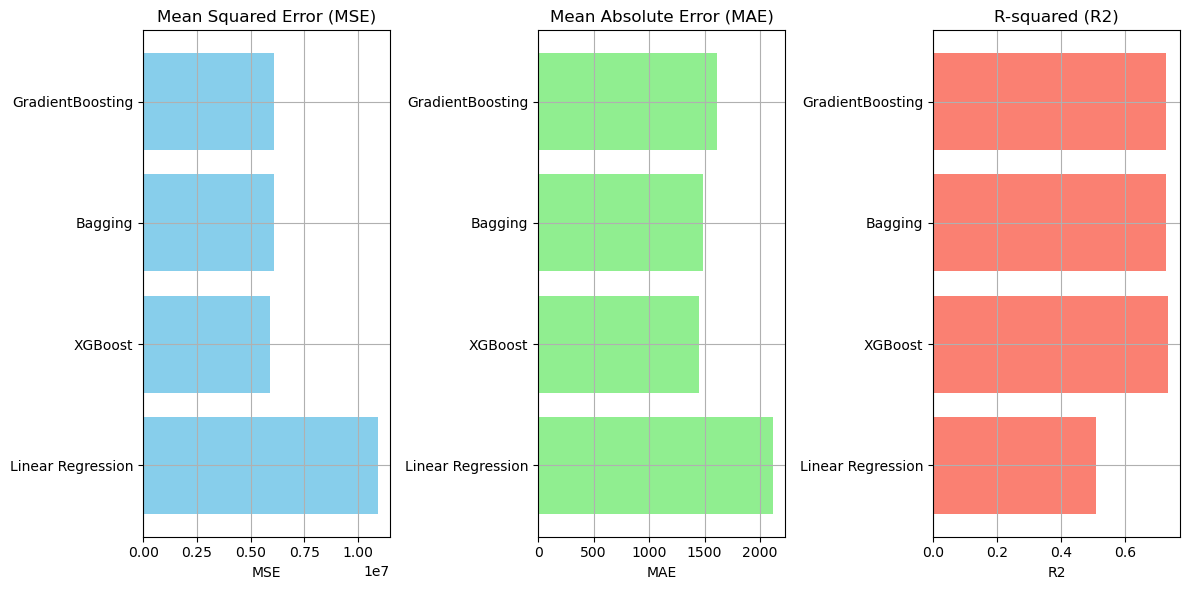

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect performance metrics of all the ML algorithms applied
results = {
    "Model": ["Linear Regression", "XGBoost", "Bagging", "GradientBoosting"],
    "MSE": [mse_linear, mse, mse_bagging, mse_boosting],
    "MAE": [mae_linear, mae, mae_bagging, mae_boosting],
    "R2": [r2_linear, r2, r2_bagging, r2_boosting]
}

# Create a DataFrame to  display the result easily and
results_df = pd.DataFrame(results)

# Display the compariso table for the ML algorithms
print("Model Comparison:")
print(results_df)

# Visualize the results in the figure
plt.figure(figsize=(12, 6))

# Plot MSE for all the algorithms
plt.subplot(1, 3, 1)
plt.barh(results_df['Model'], results_df['MSE'], color='skyblue')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('MSE')
plt.grid(True)

# Plot MAE for all the algorithms
plt.subplot(1, 3, 2)
plt.barh(results_df['Model'], results_df['MAE'], color='lightgreen')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('MAE')
plt.grid(True)

# Plot R2 for all the algorihms
plt.subplot(1, 3, 3)
plt.barh(results_df['Model'], results_df['R2'], color='salmon')
plt.title('R-squared (R2)')
plt.xlabel('R2')
plt.grid(True)

plt.tight_layout()
plt.show()